# Dataset Cleaning Pipeline

In [1]:
import pandas as pd
import os
import json
from tqdm import tqdm
import hashlib
from PIL import Image
from IPython.display import display
from dotenv import load_dotenv

load_dotenv()

C:\Users\nello\AppData\Local\Temp\ipykernel_20220\3906296117.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


True

## 1) Select the multimodal images only

### Gather and merge all the multimodal images' names from multimodal_train.tsv, multimodal_test_public.tsv and multimodal_validate.tsv and export it to json

In [13]:
multimodal_train_tsv_path = os.getenv('MULTIMODAL_TRAIN_TSV')
multimodal_test_tsv_path = os.getenv('MULTIMODAL_TEST_TSV')
multimodal_val_tsv_path = os.getenv('MULTIMODAL_VAL_TSV')

#TSV files into pd
train_df = pd.read_csv(multimodal_train_tsv_path, sep='\t')
test_df = pd.read_csv(multimodal_test_tsv_path, sep='\t')
validation_df = pd.read_csv(multimodal_val_tsv_path, sep='\t')

multimodal_images_names = list(set(train_df['id'].tolist() + test_df['id'].tolist() + validation_df['id'].tolist()))

#export the list of all the multimodal images names to json
with open(os.getenv('MULTIMODAL_IMAGES_JSON_PATH'), 'w') as json_file:
    json.dump(multimodal_images_names, json_file)

### Delete from the images dataset folder the ones that don't fall into the multimodal images json file

In [3]:
dataset_path = os.getenv('DATASET_PATH')
multimodal_images_names_json_path = os.getenv('MULTIMODAL_IMAGES_JSON_PATH')

In [28]:
with open(multimodal_images_names_json_path, 'r') as json_file:
    allowed_images = set(json.load(json_file))
print(len(allowed_images))

682661


In [24]:
def delete_non_multimodal_images(image_folder, json_file):
    print("Deleting non-multimodal images...")

    all_images = {os.path.splitext(image)[0] for image in os.listdir(image_folder)}
    images_to_delete = all_images - allowed_images
    print("All images: " + str(len(all_images)))
    print("Multimodal images: " + str(len(allowed_images)))
    print("Found " + str(len(images_to_delete)) + " images to be deleted")
    
    with tqdm(total=len(images_to_delete), desc="Deleting non-multimodal images") as pbar:
        for image_to_delete in images_to_delete:
            os.remove(os.path.join(image_folder, image_to_delete + '.jpg'))
            pbar.update(1)

    print("Done")

In [13]:
print("Dataset Cardinality before: " + str(len(os.listdir(dataset_path))) + "\n")
delete_non_multimodal_images(dataset_path, multimodal_images_names_json_path)
print("\nDataset Cardinality after: " + str(len(os.listdir(dataset_path))))

Dataset Cardinality before: 773563

Deleting non-multimodal images...
All images: 773563
Multimodal images: 682661
Found 90903 images to be deleted


Deleting non-multimodal images: 100%|██████████| 90903/90903 [03:06<00:00, 487.13it/s] 


Done

Dataset Cardinality after: 682660


## 2) "Not Available" images removal

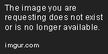

In [4]:
#image_not_found_sample = 'C:/Users/nello/Desktop/TESI_CODICE/dataset/dataset_small/1a5s5s.jpg'
image_not_found_sample = 'C:/Users/nello/Desktop/TESI_CODICE/dataset/public_image_set/1a02u2.jpg'

def display_image(image_path):
    img = Image.open(image_path)
    img.thumbnail((200, 200))
    display(img)

display_image(image_not_found_sample)

In [9]:
def file_hash(filepath):
    block_size = 65536
    file_hash = hashlib.sha256()
    with open(filepath, 'rb') as f:
        for block in iter(lambda: f.read(block_size), b''):
            file_hash.update(block)
    return file_hash.hexdigest()

In [7]:
def find_and_delete_duplicate_images(given_image_path, folder_path):
    given_image_hash = file_hash(given_image_path)
    files_list = os.listdir(folder_path)

    deleted_count = 0
    not_found_images = []

    for filename in tqdm(files_list, desc="Processing images"):
        if os.path.isfile(os.path.join(folder_path, filename)):
            current_image_path = os.path.join(folder_path, filename)
            current_image_hash = file_hash(current_image_path)

            if current_image_hash == given_image_hash:
                try:
                    os.remove(current_image_path)
                    deleted_count += 1
                    not_found_images.append(os.path.splitext(filename)[0])
                    #print(f"Deleted: {current_image_path}")
                except Exception as e:
                    print(f"Error deleting {current_image_path}: {e}")
    
    with open(os.getenv('NOT_FOUND_IMAGES_JSON_PATH'), 'w') as json_file:
        json.dump(not_found_images, json_file)

    return deleted_count

In [10]:
print("Dataset Cardinality before: " + str(len(os.listdir(dataset_path))) + "\n")
deleted_count = find_and_delete_duplicate_images(image_not_found_sample, dataset_path)
print(f'Number of images deleted: {deleted_count}')
print("\nDataset Cardinality after: " + str(len(os.listdir(dataset_path))))

Dataset Cardinality before: 679783



Processing images: 100%|██████████| 679783/679783 [18:10<00:00, 623.40it/s] 


Number of images deleted: 304

Dataset Cardinality after: 679479


In [21]:
def delete_images(delete_json_path, folder_path):
    with open(delete_json_path, 'r') as json_file:
        delete_list = json.load(json_file)
    c=0
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)

        if file_name.endswith('.jpg') and file_name[:-4] in delete_list:
            os.remove(file_path)
            c+=1
            #print(f"Deleted: {file_path}")
    return c

delete_json_path = 'C:/Users/nello/Desktop/TESI_CODICE/EDA/dataset_cleaning/delete.json'
cc=delete_images(delete_json_path, dataset_path)
print(cc)

6946


In [23]:
def count_images(folder_path):
    with os.scandir(folder_path) as entries:
        image_count = sum(1 for entry in entries if entry.is_file() and entry.name.lower().endswith('.jpg'))

    return image_count

num_images = count_images(dataset_path)

print(f"The number of images in the folder is: {num_images}")

The number of images in the folder is: 672533


#### Coherently update trains, test and val TSV files by deleting rows corresponding to the "image not found" images

In [22]:
#multimodal_train_tsv_path = os.getenv('MULTIMODAL_TSV_PATH') + "/multimodal_train_cleaned.tsv"
#multimodal_test_tsv_path = os.getenv('MULTIMODAL_TSV_PATH') + "/multimodal_test_cleaned.tsv"
#multimodal_val_tsv_path = os.getenv('MULTIMODAL_TSV_PATH') + "/multimodal_val_cleaned.tsv"

#TSV files into pd
train_df = pd.read_csv(multimodal_train_tsv_path, sep='\t')
test_df = pd.read_csv(multimodal_test_tsv_path, sep='\t')
validation_df = pd.read_csv(multimodal_val_tsv_path, sep='\t')

with open(os.getenv('NOT_FOUND_IMAGES_JSON_PATH'), 'r') as json_file:
    not_found_images = json.load(json_file)

# delete rows based on the "id" column#
train_df = train_df[~train_df['id'].isin(not_found_images)]
test_df = test_df[~test_df['id'].isin(not_found_images)]
validation_df = validation_df[~validation_df['id'].isin(not_found_images)]

# convert back the filtered df to TSV files
train_df.to_csv(os.getenv('MULTIMODAL_TSV_PATH') + "/multimodal_train_cleaned.tsv", sep='\t', index=False)
test_df.to_csv(os.getenv('MULTIMODAL_TSV_PATH') + "/multimodal_test_cleaned.tsv", sep='\t', index=False)
validation_df.to_csv(os.getenv('MULTIMODAL_TSV_PATH') + "/multimodal_val_cleaned.tsv", sep='\t', index=False)

## 3) Exact Duplicate detection (same image + same text)

### Duplicate post detection (same image + same text) and deduplication (keeping only one post)

#### create a json file all_post_hash_x_title.json that contains for each post the image hash, the caption (title), the image id and the original set:
```json
{"awxhir": {"hash": "1d3bee9c40", "title": "my walgreens offbrand mucinex was engraved", "set": "training"}, ... }

In [25]:
def create_image_hash_dict(df, image_folder, set):
    image_hash_dict = {}

    #c=0
    for index, row in tqdm(df.iterrows(), total=len(df), desc='Processing Images'):
        #if c==2000:
            #break
        image_id = row['id']
        image_title = row['clean_title']
        image_path = os.path.join(image_folder, f"{image_id}.jpg")
        #c+=1
        if os.path.isfile(image_path):
            hash_value = file_hash(image_path)
            image_hash_dict[image_id] = {'hash': hash_value, 'title': image_title, 'set': set}
        else:
            print(f"Image not found: {image_path}")
            continue
        
    return image_hash_dict

In [26]:
with tqdm(total=3, desc='Creating Image Hash Dictionaries') as pbar:
    # image_x_hash dictionaries for each df
    train_image_hash_dict = create_image_hash_dict(train_df, dataset_path, "training")
    pbar.update(1) 
    test_image_hash_dict = create_image_hash_dict(test_df, dataset_path, "test")
    pbar.update(1) 
    validation_image_hash_dict = create_image_hash_dict(validation_df, dataset_path, "validation")
    pbar.update(1)  

# merge dicts
combined_image_hash_dict = {**train_image_hash_dict, **test_image_hash_dict, **validation_image_hash_dict}

with open(os.getenv("POSTS_HASH_AND_TITLE_JSON_PATH"), 'w') as json_file:
    json.dump(combined_image_hash_dict, json_file)

print("Done. Results exported to all_posts_hash_x_title.json")

Creating Image Hash Dictionaries:   0%|          | 0/3 [00:00<?, ?it/s]

Image not found: C:/Users/nello/Desktop/TESI_CODICE/dataset/public_image_set\crmnpjl.jpg


Creating Image Hash Dictionaries: 100%|██████████| 3/3 [22:35<00:00, 451.73s/it]


Done. Results exported to all_posts_hash_x_title.json


In [6]:
with open(os.getenv('POSTS_HASH_AND_TITLE_JSON_PATH'), 'r') as json_file:
    combined_image_hash_dict = json.load(json_file)
print(len(combined_image_hash_dict))

672533


#### create a json file exact_duplicates_images.json that contains all the posts that have same image hash + text:
 ```json
 {
  "332a1dde7933245_report reveals jesus christ have benefited from fathers": {
    "hash": "332a1dde7933245",
    "title": "report reveals jesus christ have benefited from fathers",
    "duplicates": [
      {
        "image_id": "baydyy",
        "image_set": "training"
      },
      {
        "image_id": "b8694x",
        "image_set": "test"
      }
    ]
  }, ... }

In [4]:
with open(os.getenv("POSTS_HASH_AND_TITLE_JSON_PATH"), "r") as json_file:
    existing_data = json.load(json_file)

exact_duplicates_dict = {} 

for image_id, info in tqdm(existing_data.items(), desc='Detecting exact duplicates', unit='image'):
    hash_value = info['hash']
    title = info['title']
    image_set = info['set']

    #get a unique identifier for each image composed of the hash and title
    identifier = f"{hash_value}_{title}"

    #check if the identifier is already encountered
    if identifier in exact_duplicates_dict:
        #here duplicate found, add the current image_id and set to the duplicates list
        exact_duplicates_dict[identifier]['duplicates'].append({'image_id': image_id, 'image_set': image_set})
    else:
        #here instead i have first occurrence of this identifier, so i create a new entry
        exact_duplicates_dict[identifier] = {'hash': hash_value, 'title': title, 'duplicates': [{'image_id': image_id, 'image_set': image_set}]}

#filter out entries with only one image (no duplicates)
exact_duplicates_dict = {key: value for key, value in exact_duplicates_dict.items() if len(value['duplicates']) > 1}

with open(os.getenv("EXACT_DUPLICATE_IMAGE_JSON_PATH"), 'w') as json_file:
    json.dump(exact_duplicates_dict, json_file, indent=2)

print("Done. Results exported to exact_duplicates_image.json")


Detecting Duplicates: 100%|██████████| 672533/672533 [00:02<00:00, 243041.12image/s]


Done. Results exported to exact_duplicates_image.json


In [10]:
with open(os.getenv("EXACT_DUPLICATE_IMAGE_JSON_PATH"), "r") as json_file:
    exact_duplicates = json.load(json_file)
print(len(exact_duplicates))

3457


#### Now i create a json choosen_duplicate_to_maintain.json that contains only 1 post among all the duplicates, 
#### prioritizing the ones that comes from the test set over the training/validation set:

```json
{
  "332a1dde7933245_report reveals jesus christ have benefited from fathers": {
    "hash": "332a1dde7933245d028e7f873480e1b1f8a5cbb496fc5f6c96d237982bd12853",
    "title": "report reveals jesus christ have benefited from fathers",
    "duplicates": [
      "baydyy"
    ]
  }, ... }

In [8]:
with open(os.getenv("POSTS_HASH_AND_TITLE_JSON_PATH"), "r") as json_file:
    existing_data = json.load(json_file)

exact_duplicates_dict = {} 

for image_id, info in tqdm(existing_data.items(), desc='Detecting Duplicates to maintain', unit='image'):
    hash_value = info['hash']
    title = info['title']
    image_set = info['set']

    # Create a unique identifier for each image based on hash and title
    identifier = f"{hash_value}_{title}"

    # Check if the identifier is already encountered
    if identifier in exact_duplicates_dict:
        # Duplicate found, add the current image_id to the duplicates list
        exact_duplicates_dict[identifier]['duplicates'].append((image_id, image_set))
    else:
        # First occurrence of this identifier, create a new entry
        exact_duplicates_dict[identifier] = {'hash': hash_value, 'title': title, 'duplicates': [(image_id, image_set)]}

# Filter out entries with only one image (no duplicates)
exact_duplicates_dict = {key: value for key, value in exact_duplicates_dict.items() if len(value['duplicates']) > 1} 

# Keep only one image from each set of duplicates, prioritize test set if present
filtered_duplicates_dict = {}
for identifier, data in exact_duplicates_dict.items():
    duplicates = data['duplicates']
    
    # Check if there is at least one image from the test set
    test_set_duplicates = [(image_id, image_set) for image_id, image_set in duplicates if image_set == 'test']
    
    if test_set_duplicates:
        # Keep only one image from the test set
        filtered_duplicates_dict[identifier] = {'hash': data['hash'], 'title': data['title'], 'duplicates': [test_set_duplicates[0][0]]}
    else:
        # If no test set images, keep one from training/validation set
        filtered_duplicates_dict[identifier] = {'hash': data['hash'], 'title': data['title'], 'duplicates': [duplicates[0][0]]}

with open(os.getenv("CHOOSEN_DUPLICATE_TO__MAINTAIN_JSON_PATH"), 'w') as json_file:
    json.dump(filtered_duplicates_dict, json_file, indent=2)

print(f"Done. Results exported to choosen_duplicates_to_maintain.json")

Detecting Duplicates to maintain: 100%|██████████| 672533/672533 [00:02<00:00, 258353.97image/s]


Done. Results exported to choosen_duplicates_to_maintain.json


In [13]:
with open(os.getenv("CHOOSEN_DUPLICATE_TO__MAINTAIN_JSON_PATH"), "r") as json_file:
    duplicates_to_maintain = json.load(json_file)
print(len(duplicates_to_maintain))

3457


#### Now i create another json duplicates_to_delete.json that contains the post ids to delete (not choosen):
```json
[
  {
    "image_id": "b8694x",
    "image_set": "training"
  },
  {
    "image_id": "er6eggt",
    "image_set": "training"
  }, ...
]

In [4]:
with open(os.getenv("EXACT_DUPLICATE_IMAGE_JSON_PATH"), "r") as json_file:
    exact_duplicates = json.load(json_file)
print(len(exact_duplicates))

with open(os.getenv("CHOOSEN_DUPLICATE_TO__MAINTAIN_JSON_PATH"), "r") as json_file:
    duplicates_to_maintain = json.load(json_file)
print(len(duplicates_to_maintain))

3457
3457


In [19]:
duplicates_to_delete = []
for key_b, value_b in exact_duplicates.items():
    if key_b in duplicates_to_maintain:
        duplicates_a = duplicates_to_maintain[key_b]["duplicates"]
        duplicates_b = value_b["duplicates"]
        images_to_delete = [
            {"image_id": item["image_id"], "image_set": item["image_set"]}
            for item in duplicates_b
            if item["image_id"] not in duplicates_a
        ]
        duplicates_to_delete.extend(images_to_delete)

with open(os.getenv("DUPLICATE_TO_DELETE_JSON_PATH"), "w") as json_file:
    json.dump(duplicates_to_delete, json_file, indent=2)

print(f"Done. Results exported to duplicates_to_delete.json")

Done. Results exported to duplicates_to_delete.json


In [3]:
with open(os.getenv("DUPLICATE_TO_DELETE_JSON_PATH"), "r") as json_file:
    duplicates_to_delete = json.load(json_file)
print(len(duplicates_to_delete))

3815


#### Now that i have identified all the duplicate posts to delete, i can proceed to delete all the images that have the id inside duplicates_to_delete.json
#### and to coherently delete the corresponding rows from the .tsv of train, test and val

In [5]:
multimodal_train_tsv_path = os.getenv('MULTIMODAL_TRAIN_CLEANED_TSV')
multimodal_test_tsv_path = os.getenv('MULTIMODAL_TEST_CLEANED_TSV')
multimodal_val_tsv_path = os.getenv('MULTIMODAL_VAL_CLEANED_TSV')

train_df = pd.read_csv(multimodal_train_tsv_path, sep='\t')
test_df = pd.read_csv(multimodal_test_tsv_path, sep='\t')
validation_df = pd.read_csv(multimodal_val_tsv_path, sep='\t')

print("train len before: " + str(len(train_df)))
print("test len before: " + str(len(test_df)))
print("val len before: " + str(len(validation_df)))

c = 0

for image_info in tqdm(duplicates_to_delete, desc="Deleting files"):
    image_id = image_info["image_id"]
    image_set = image_info["image_set"]

    file_path = os.path.join(dataset_path, f"{image_id}.jpg")

    if os.path.exists(file_path):
        os.remove(file_path)
        c += 1
        #print(f"Deleted file: {file_path}")

    #i update the corresponding dataframe based on image_set value
    if image_set == "training":
        train_df = train_df[train_df["id"] != image_id]
    elif image_set == "test":
        test_df = test_df[test_df["id"] != image_id]
    elif image_set == "validation":
        validation_df = validation_df[validation_df["id"] != image_id]

#convert back the filtered df to TSV files
train_df.to_csv(os.getenv('MULTIMODAL_TRAIN_CLEANED_NO_EXACT_DUPLICATES_TSV'), sep='\t', index=False)
test_df.to_csv(os.getenv('MULTIMODAL_TEST_CLEANED_NO_EXACT_DUPLICATES_TSV'), sep='\t', index=False)
validation_df.to_csv(os.getenv('MULTIMODAL_VAL_CLEANED_NO_EXACT_DUPLICATES_TSV'), sep='\t', index=False)

print("train len after: " + str(len(train_df)))
print("test len after: " + str(len(test_df)))
print("val len after: " + str(len(validation_df)))

print(str(c) + " files deleted")


train len before: 555695
test len before: 58411
val len before: 58428


Deleting files: 100%|██████████| 3815/3815 [11:15<00:00,  5.65it/s]


train len after: 552509
test len after: 58387
val len after: 57823
3815 files deleted


In [7]:
print("\nDataset Cardinality after: " + str(len(os.listdir(dataset_path))))


Dataset Cardinality after: 668718


## 4) Image-only Duplicates Detection

### We check whether there are images inside training set that have duplicate (image only) inside the test set and we delete it

firstly, create a json file containing for each post in training set, its duplicates (if any) inside the test set, considering same image only and different title:
```json
{
  "5c61go": [
    "53lt6a",
    "5j4ikh",
    "6174si",
    "503e06",
    "17n5ea"
  ], ...
}

In [14]:
multimodal_train_tsv_path = os.getenv('MULTIMODAL_TRAIN_CLEANED_NO_EXACT_DUPLICATES_TSV')
multimodal_test_tsv_path = os.getenv('MULTIMODAL_TEST_CLEANED_NO_EXACT_DUPLICATES_TSV')

train_df = pd.read_csv(multimodal_train_tsv_path, sep='\t')
test_df = pd.read_csv(multimodal_test_tsv_path, sep='\t')

duplicates_mapping = {}

#precompute hashes for both training and test images
train_hashes = {}
for _, train_row in tqdm(train_df.iterrows(), total=len(train_df), desc="Precomputing train hashes"):
    train_image_id = train_row['id']
    train_image_path = os.path.join(dataset_path, f"{train_image_id}.jpg")
    try:
        train_hashes[train_image_id] = file_hash(train_image_path)
    except Exception as e:
        print(f"Error computing hash for {train_image_id}: {e}")

test_hashes = {}
for _, test_row in tqdm(test_df.iterrows(), total=len(test_df), desc="Precomputing test hashes"):
    test_image_id = test_row['id']
    test_image_path = os.path.join(dataset_path, f"{test_image_id}.jpg")
    try:
        test_hashes[test_image_id] = file_hash(test_image_path)
    except Exception as e:
        print(f"Error computing hash for {test_image_id}: {e}")

for _, train_row in tqdm(train_df.iterrows(), total=len(train_df), desc="Processing training set"):
    train_image_id = train_row['id']
    try:
        train_image_hash = train_hashes[train_image_id]
    except KeyError:
        print(f"Hash not found for {train_image_id}")
        continue 

    #check for duplicates in the test set using precomputed hashes
    duplicates_in_test = [
        test_image_id for test_image_id, test_hash in test_hashes.items()
        if train_image_hash == test_hash
    ]

    #only add entries for training images with duplicates
    if duplicates_in_test:
        duplicates_mapping[train_image_id] = duplicates_in_test

with open(os.getenv('IMAGE_ONLY_DUPLICATES_MAPPING_TRAIN_TEST_JSON_PATH'), "w") as json_file:
    json.dump(duplicates_mapping, json_file, indent=2)

print("Duplicates mapping saved to only_images_duplicates_mapping_train_test.json")

Precomputing train hashes:  74%|███████▍  | 409086/552509 [11:58<04:48, 497.57it/s] 

Error computing hash for crmnpjl: [Errno 2] No such file or directory: 'C:/Users/nello/Desktop/TESI_CODICE/dataset/public_image_set\\crmnpjl.jpg'


Processing training set:  74%|███████▍  | 409095/552509 [22:41<07:55, 301.46it/s]

Hash not found for crmnpjl


Processing training set: 100%|██████████| 552509/552509 [30:39<00:00, 300.43it/s]


Duplicates mapping saved to duplicates_mapping.json


In [15]:
print(len(duplicates_mapping))

6376


now i can delete the image-only duplicates in the training set, and maintain the ones in the test set:

In [6]:
multimodal_train_tsv_path = os.getenv('MULTIMODAL_TRAIN_CLEANED_NO_EXACT_DUPLICATES_TSV')

train_df = pd.read_csv(multimodal_train_tsv_path, sep='\t')

with open(os.getenv('IMAGE_ONLY_DUPLICATES_MAPPING_TRAIN_TEST_JSON_PATH'), "r") as json_file:
    duplicates_mapping = json.load(json_file)

unique_training_images = list(set(duplicates_mapping.keys()))

#backup the list of all the duplicates of the training image that are going to be deleted in a json file
with open(os.getenv('IMAGE_ONLY_DUPLICATES_DELETED_TRAINING'), "w") as json_file:
    json.dump(unique_training_images, json_file, indent=2)

c=0
#delete training images and maintain only the duplicates in the test set (same images but different text)
for filename in tqdm(os.listdir(dataset_path), desc="Deleting training images"):
    image_id, _ = os.path.splitext(filename)

    if image_id in unique_training_images:
        file_path = os.path.join(dataset_path, filename)
        os.remove(file_path)
        #print(f"Deleted file: {file_path}")
        c+=1

print("Deleted "+str(c)+ " images from training set")

#update the training.tsv file to remove rows corresponding to the deleted training images
train_df = pd.read_csv(multimodal_train_tsv_path, sep='\t')
train_df = train_df[~train_df['id'].isin(unique_training_images)]
train_df.to_csv(os.getenv("MULTIMODAL_TRAIN_CLEANED_NO_EXACT_DUPLICATES_NO_IMAGEONLY_DUPLICATES_TSV"), sep='\t', index=False)

print("Removed "+str(c)+ " rows from training .tsv file")

Deleting training images: 100%|██████████| 668718/668718 [01:19<00:00, 8420.12it/s] 


Deleted 6376 images from training set
Removed 6376 rows from training .tsv file


In [7]:
print("\nDataset Cardinality after: " + str(len(os.listdir(dataset_path))))


Dataset Cardinality after: 662342


## 5) Delete all the corrupted images in the dataset

Specifically, the images that have too many megapixels (cause DecompressionBombError while processing) and images that are corrupted (cannot identify image file)

In [4]:
import os
import pandas as pd
from dotenv import load_dotenv

load_dotenv()

multimodal_train_tsv_path = os.getenv('MULTIMODAL_TRAIN_CLEANED_NO_EXACT_DUPLICATES_NO_IMAGEONLY_DUPLICATES_TSV')
multimodal_test_tsv_path = os.getenv('MULTIMODAL_TEST_CLEANED_NO_EXACT_DUPLICATES_TSV')
multimodal_validation_path = os.getenv('MULTIMODAL_VAL_CLEANED_NO_EXACT_DUPLICATES_TSV')

train_df = pd.read_csv(multimodal_train_tsv_path, sep='\t')
test_df = pd.read_csv(multimodal_test_tsv_path, sep='\t')
val_df = pd.read_csv(multimodal_validation_path, sep='\t')

In [5]:
print(f"train Cardinality: {len(train_df)}")
print(f"test Cardinality: {len(test_df)}")
print(f"val Cardinality: {len(val_df)}")

print("\nDataset images cardinality: " + str(len(train_df)+len(test_df)+len(val_df)))

train Cardinality: 546133
test Cardinality: 58387
val Cardinality: 57823

Dataset images cardinality: 662343


In [6]:
DATASET_DIR = os.getenv('DATASET_DIR')
CORRUPTED_IMAGES_JSON_PATH = os.getenv('CORRUPTED_IMAGES_JSON_PATH')
MAX_MEGAPIXELS = 10.0

Firstly, create a corrupted_images.json file that contains all the names of the images that have either too many pixels or that does not contain image file

In [7]:
from PIL import Image
from tqdm import tqdm
import pandas as pd
import os
import json

def calculate_max_dimensions(max_megapixels, aspect_ratio):
    max_pixels = int(max_megapixels * 1e6)
    height = int((max_pixels / aspect_ratio) ** 0.5)
    width = int(aspect_ratio * height)
    return width, height

def delete_corrupted_images(input_folder, max_megapixels):

    corrupted_images = []
    num_images_removed = 0

    filenames = os.listdir(input_folder)
    for filename in tqdm(filenames, desc="Processing Images", unit="image"):
        file_path = os.path.join(input_folder, filename)

        try:
            with Image.open(file_path) as img:
                aspect_ratio = img.width / img.height
                max_width, max_height = calculate_max_dimensions(max_megapixels, aspect_ratio)

                # Check if the image exceeds the maximum size
                if img.width > max_width or img.height > max_height:
                    corrupted_images.append({"filename": os.path.splitext(filename)[0], "error": "Size exceeds limit"})
                    num_images_removed += 1
                    #os.remove(file_path)

        except Exception as e:
            corrupted_images.append({"filename": os.path.splitext(filename)[0], "error": str(e).split("'")[0]})
            num_images_removed += 1
            #os.remove(file_path) 

    # Export list of dictionaries to JSON
    with open(CORRUPTED_IMAGES_JSON_PATH, "w") as json_file:
        json.dump(corrupted_images, json_file, indent=2)

    print(f"Number of Images Removed: {num_images_removed}")

In [ ]:
delete_corrupted_images(DATASET_DIR, MAX_MEGAPIXELS)

Restore the corrupted_images.tsv file

In [61]:
corrupted_images_df = pd.read_json(CORRUPTED_IMAGES_JSON_PATH)

Then, delete coherently all the rows corresponding to the corrupted image names inside the DataFrames of train, test and val

In [64]:
def delete_corrupted_images_from_df(df, corrupted_images_df):
    # Identify rows in the dataframe corresponding to corrupted images
    corrupted_filenames = set(corrupted_images_df['filename'])
    mask = df['id'].isin(corrupted_filenames)

    # Remove corrupted rows from the dataframe
    df_cleaned = df[~mask]

    return df_cleaned

In [63]:
MULTIMODAL_TRAIN_CLEANED_NO_EXACT_DUPLICATES_NO_IMAGEONLY_DUPLICATES_NO_CORRUPTED_TSV = os.getenv('MULTIMODAL_TRAIN_CLEANED_NO_EXACT_DUPLICATES_NO_IMAGEONLY_DUPLICATES_NO_CORRUPTED_TSV')
MULTIMODAL_TEST_CLEANED_NO_EXACT_DUPLICATES_NO_CORRUPTED_TSV = os.getenv('MULTIMODAL_TEST_CLEANED_NO_EXACT_DUPLICATES_NO_CORRUPTED_TSV')
MULTIMODAL_VAL_CLEANED_NO_EXACT_DUPLICATES_NO_CORRUPTED_TSV = os.getenv('MULTIMODAL_VAL_CLEANED_NO_EXACT_DUPLICATES_NO_CORRUPTED_TSV')

In [67]:
train_df_cleaned = delete_corrupted_images_from_df(train_df, corrupted_images_df)
train_df_cleaned.to_csv(MULTIMODAL_TRAIN_CLEANED_NO_EXACT_DUPLICATES_NO_IMAGEONLY_DUPLICATES_NO_CORRUPTED_TSV, sep='\t', index=False)

In [65]:
test_df_cleaned = delete_corrupted_images_from_df(test_df, corrupted_images_df)
test_df_cleaned.to_csv(MULTIMODAL_TEST_CLEANED_NO_EXACT_DUPLICATES_NO_CORRUPTED_TSV, sep='\t', index=False)

In [66]:
val_df_cleaned = delete_corrupted_images_from_df(val_df, corrupted_images_df)
val_df_cleaned.to_csv(MULTIMODAL_VAL_CLEANED_NO_EXACT_DUPLICATES_NO_CORRUPTED_TSV, sep='\t', index=False)

Check the cardinalities after removal

In [70]:
print(f"train Cardinality: {len(train_df_cleaned)}")
print(f"test Cardinality: {len(test_df_cleaned)}")
print(f"val Cardinality: {len(val_df_cleaned)}")

print("\nDataset images cardinality: " + str(len(train_df_cleaned)+len(test_df_cleaned)+len(val_df_cleaned)))

train Cardinality: 542997
test Cardinality: 58047
val Cardinality: 57489

Dataset images cardinality: 658533


## 6) Update the all_comments.tsv deleting the ones related to the removed posts

In [2]:
multimodal_train_tsv_path = os.getenv('MULTIMODAL_TRAIN_CLEANED_NO_EXACT_DUPLICATES_NO_IMAGEONLY_DUPLICATES_NO_CORRUPTED_TSV')
multimodal_test_tsv_path = os.getenv('MULTIMODAL_TEST_CLEANED_NO_EXACT_DUPLICATES_NO_CORRUPTED_TSV')
multimodal_validation_path = os.getenv('MULTIMODAL_VAL_CLEANED_NO_EXACT_DUPLICATES_NO_CORRUPTED_TSV')
all_comments_tsv_path = os.getenv('ALL_COMMENTS_TSV')

train_df = pd.read_csv(multimodal_train_tsv_path, sep='\t')
test_df = pd.read_csv(multimodal_test_tsv_path, sep='\t')
val_df = pd.read_csv(multimodal_validation_path, sep='\t')
all_comments_df = pd.read_csv(all_comments_tsv_path, sep='\t')

C:\Users\nello\AppData\Local\Temp\ipykernel_20220\1142979992.py:9: DtypeWarning: Columns (0,1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  all_comments_df = pd.read_csv(all_comments_tsv_path, sep='\t')


In [3]:
unique_ids = set(train_df['id']).union(set(test_df['id'])).union(set(val_df['id']))

print("Cardinality of comments .tsv before:", len(all_comments_df))

#i keep only the rows in all_comments where submission_id is present in the unique IDs in the union of train, test and val
filtered_comments_df = all_comments_df[all_comments_df['submission_id'].isin(unique_ids)]

print("Cardinality of comments .tsv after:", len(filtered_comments_df))

# Save the filtered comments to a new TSV file
filtered_comments_df.to_csv(os.getenv('ALL_COMMENTS_CLEANED_TSV'), sep='\t', index=False)

print("Filtered comments saved to all_comments_cleaned.tsv")

Cardinality of comments .tsv before: 10697533
Cardinality of comments .tsv after: 6132032
Filtered comments saved to all_comments_cleaned.tsv
